# Chapter 3: Classification
This work is partialy combined text and code from the book [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) is only supposed to be used as reference and is recommended to follow along with a copy of the Book puchased.

## You have to plot more!
[Ch3 Google Colab](https://colab.research.google.com/github/ageron/handson-ml2/blob/master/03_classification.ipynb#scrollTo=MghIe6UFnBo-)  

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)


(70000, 784)
(70000,)


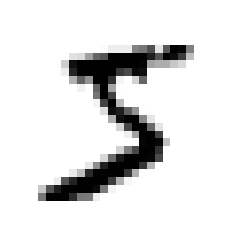

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0]
another_digit = X.iloc[1]
some_digit_image = some_digit.values.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()
# print('Label:', y.iloc[0])


In [ ]:
import numpy as np
y = y.astype(np.uint8)

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000],y[60000:]

# Training a Binary Classifier

In [ ]:
# Let's create the target vector for this classification task
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5) 

In [ ]:
y_test

60000    7
60001    2
60002    1
60003    0
60004    4
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 10000, dtype: uint8

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit, another_digit])

array([ True, False])

# Performance Measures

## Measuring Accuracy Using Cross_Validation

### Implementing Cross-Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=2, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

In [ ]:
from sklearn.model_selection import  cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

In [ ]:
# With 95% of accuracy let's look at dumb classifier that just classifies every single image in the not 'not-5' class.

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

### Confusion Matrix

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

In [ ]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

**Precision:** For what fraction of ***positive predictions*** are *correct*

**Recall:** What fraction of ***positive instances*** does the the classifier correctly identify as *positive*.

In [ ]:
from sklearn.metrics import precision_score, recall_score

print('Precision Score: ',precision_score(y_train_5, y_train_pred))
print('Recall Score:    ',recall_score(y_train_5, y_train_pred))

When it claims an image represents 5, it is correct only 83% of the time.

It only detects 65% of the 5s (Positive instances)

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [ ]:
# Changing the threshold using descision_function which returns a score of each instance
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
threshold = 0
y_some_digit_prediction = (y_scores > threshold)
y_some_digit_prediction

array([ True])

In [ ]:
threshold = 8000
y_some_digit_prediction = (y_scores > threshold)
y_some_digit_prediction

array([False])

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

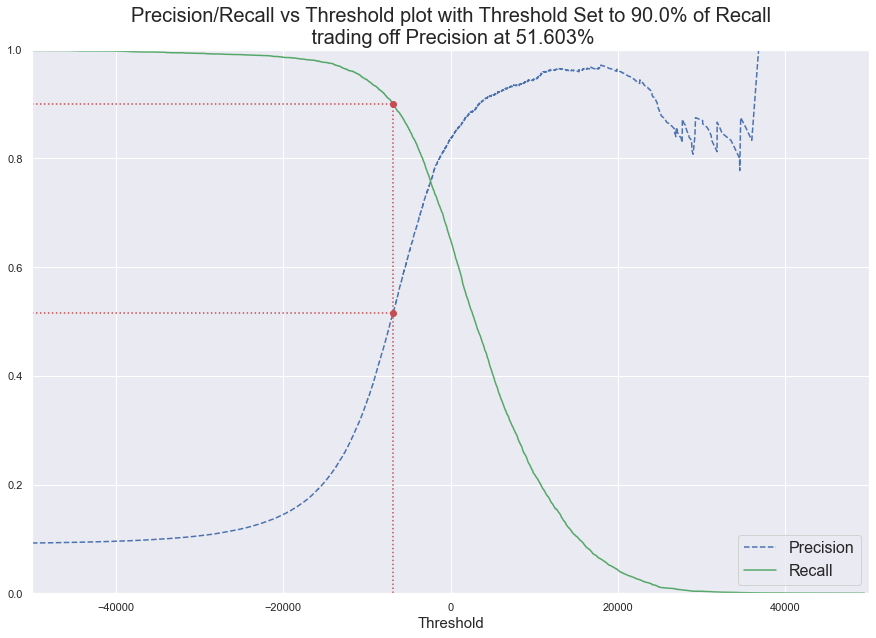

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, metric_name=None, metric_perc=None):
    plt.figure(figsize=(15, 10))
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold', fontsize=15)
    plt.axis([-50000, 50000, 0, 1])
    plt.legend(loc='best', fontsize=16)
    
    if metric_name=='precision':
        metric = precisions
        tradedoff_metric = recalls
        tradedoff_metric_name = 'Recall'
        # tradedoff metric & threshold at percentage metric we want.
        tradedoff_atperc_metric = tradedoff_metric[np.argmax(metric >= metric_perc)] 
        threshold_atperc_metric = thresholds[np.argmax(metric >= metric_perc)]
    elif metric_name == 'recall':
        metric = recalls
        tradedoff_metric = precisions
        tradedoff_metric_name = 'Precision'
        # tradedoff metric & threshold at percentage metric we want.
        tradedoff_atperc_metric = tradedoff_metric[np.argmax(metric <= metric_perc)] 
        threshold_atperc_metric = thresholds[np.argmax(metric <= metric_perc)]
    else:
        return
    # Draw the threholds, red dotted vertical line
    plt.plot([threshold_atperc_metric, threshold_atperc_metric], [0., metric_perc], "r:")
    # Draw the two horizontal dotted line for precision and recall
    plt.plot([-50000, threshold_atperc_metric], [metric_perc, metric_perc], "r:")
    plt.plot([-50000, threshold_atperc_metric], [tradedoff_atperc_metric, tradedoff_atperc_metric ], "r:")
    # Draw the two dots
    plt.plot([threshold_atperc_metric], [metric_perc], "ro")
    plt.plot([threshold_atperc_metric], [tradedoff_atperc_metric], "ro")
    plt.title("Precision/Recall vs Threshold plot with Threshold Set to {}% of {}\n trading off {} at {:.3f}%".format(
        metric_perc*100, 
        metric_name.capitalize(), 
        tradedoff_metric_name,
        tradedoff_atperc_metric*100), fontsize=20)
    plt.show()
    return threshold_atperc_metric
    
threshold = plot_precision_recall_vs_threshold(precisions, recalls, thresholds, 'recall', 0.9)

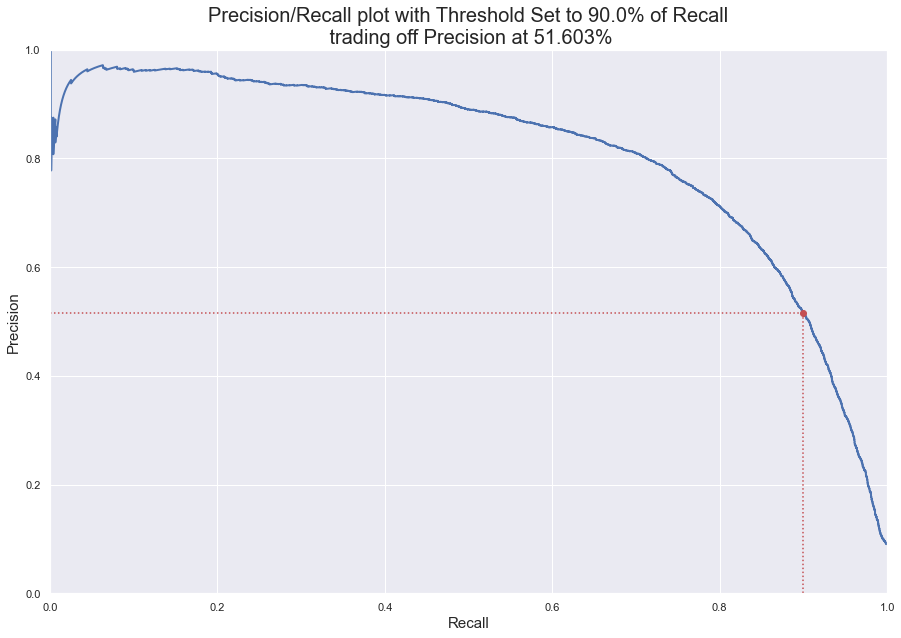

In [ ]:
def plot_precision_vs_recall(precisions, recalls, metric_name=None, metric_perc=None):
    plt.figure(figsize=(15, 10))
    plt.plot(recalls, precisions, 'b-', linewidth=2)
    plt.xlabel("Recall", fontsize=15)
    plt.ylabel("Precision", fontsize=15)
    plt.axis([0, 1, 0, 1])
    if metric_name=='precision':
        # tradedoff recall  & threshold at percentage precision we want.
        recall_atperc_precision = recalls[np.argmax(precisions >= metric_perc)] 
        threshold_atperc_precision = thresholds[np.argmax(precisions >= metric_perc)]
        plt.plot([recall_atperc_precision, recall_atperc_precision], [0., metric_perc], 'r:')
        plt.plot([0., recall_atperc_precision], [metric_perc, metric_perc], "r:")
        plt.plot([recall_atperc_precision], [metric_perc], 'ro')
        plt.title("Precision/Recall plot with Threshold Set to {}% of {}\n trading off Recall at {:.3f}%".format(
            metric_perc*100, 
            metric_name.capitalize(), 
            tradedoff_atperc_metric*100), fontsize=20)
        plt.show()
        return threshold_atperc_precision
    elif metric_name == 'recall':
        # tradedoff precision & threshold at percentage recall we want.
        precision_atperc_recall = precisions[np.argmax(recalls <= metric_perc)] 
        threshold_atperc_recall = thresholds[np.argmax(recalls <= metric_perc)]
        plt.plot([0., metric_perc],[precision_atperc_recall, precision_atperc_recall], 'r:')
        plt.plot([metric_perc, metric_perc],[0., precision_atperc_recall], "r:")
        plt.plot([metric_perc],[precision_atperc_recall], 'ro')
        plt.title("Precision/Recall plot with Threshold Set to {}% of {}\n trading off Precision at {:.3f}%".format(
            metric_perc*100, 
            metric_name.capitalize(), 
            precision_atperc_recall*100), fontsize=20)
        plt.show()
        return threshold_atperc_recall
    else:
        return

threshold = plot_precision_vs_recall_new(precisions, recalls, 'recall', 0.9)

In [ ]:
## from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #dashed diagonal
    # [...] add asix labels and grid

plot_roc_curve(fpr, tpr)

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5 , y_scores)

0.9604938554008616

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

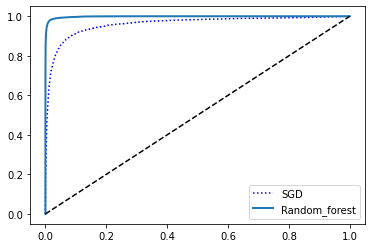

In [ ]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random_forest')
plt.legend()
plt.show()

# Multiclass Classification

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])

In [ ]:
np.argmax(some_digit_scores)

5

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
# If you want to force scikit-learn to use either OVR, OVO strategy
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
over_clf.predict([some_digit])

In [ ]:
len(ovr_clf.estimators_)

In [ ]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

### Error Analysis

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

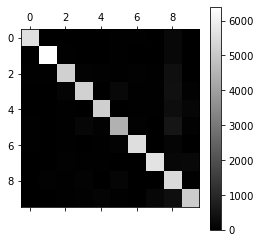

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.colorbar()

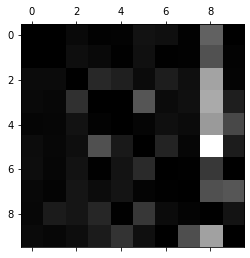

In [ ]:
rows_sum = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / rows_sum

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

NameError: name 'plot_digits' is not defined

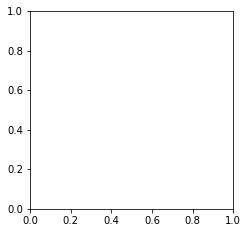

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)    
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

# Multilabel Classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

NameError: name 'f1_score' is not defined

In [ ]:
f1_score(y_multilabel, y_train_knn_pred, average='weighted')

In [ ]:
noise = np.random.randint(0, 100, (len(X_train, 784)))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[5]])
plot_digit(clean_digit)